### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline


import keras
import keras.layers as L

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)

data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
17310,66924601,"Business Intelligence Developer RossonWye, He...","Business Intelligence Developer RossonWye, He...","England, UK",UK,NaN,permanent,Evolution Recruitment Solutions,IT Jobs,35000 - 39999/annum please contact agency for ...,37499,cv-library.co.uk,10.532096
211733,72221728,Senior Web Developer Healthcare,"Senior Web Developer Healthcare Our client, a...",Belfast,Belfast,NaN,permanent,ARRAY,HR & Recruitment Jobs,35000 - 45000,40000,recruitni.com,10.596660
184789,71659891,PASTRY CHEF,Employer: One of the leading kitchens in St. A...,"St. Andrews, Fife, Fife, UK, Greater London",London,NaN,NaN,Aston Recruitment,Hospitality & Catering Jobs,"23-25,000",24000,jobs.catererandhotelkeeper.com,10.085851


In [3]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# see task above
for column in text_columns:
    data[column] = data[column].astype(str).apply(str.lower)
    data[column] = data[column].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

In [4]:
from collections import Counter as Counter
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
token_counts = Counter()

for col in text_columns:
    for words in data[col]:
        token_counts.update(words.split(' '))
        
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = {token for token, count in token_counts.items() if count >= min_count}

UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)

#Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)
token_to_id = {token: i for i, token in enumerate(tokens)}

And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [5]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [6]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [7]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.3, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  171337
Validation size =  73431


In [8]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...

In [9]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    

    emb = L.Embedding(n_tokens, hid_size)
    
    l_title_emb = emb(l_title)
    l_title_conv = L.Conv1D(filters=hid_size, kernel_size=3, activation='tanh')(l_title_emb)
    l_title_out = L.GlobalMaxPool1D()(l_title_conv)
    
    
    l_descr_emb = emb(l_descr)
    l_descr_conv = L.Conv1D(filters=hid_size,kernel_size=3, activation='tanh')(l_descr_emb)
    l_descr_out = L.GlobalMaxPool1D()(l_descr_conv)
    
    
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)
    
    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    l_combined_dense = L.Dense(2*hid_size, activation='relu')(l_combined)
    
    before_dropout = L.Dense(1)(l_combined_dense)    
    
    dropout1 = L.Dropout(0.10)(before_dropout)
    output_layer = L.Dense(units=1, activation='relu')(dropout1)
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     2186112     Title[0][0]                      
                                                                 FullDescription[0][0]            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 64)     12352       embedding[0][0]              

In [10]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from datetime import datetime
from packaging import version

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
batch_size = 256
epochs = 30          
steps_per_epoch = (len(data_train) - 1) // batch_size + 1  # for full pass over data: 

model = build_model()

earlystopper = EarlyStopping(patience=3, verbose=1)
callbacks_list = [earlystopper, tensorboard_callback]

history = model.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    callbacks=callbacks_list,
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size, verbose= 0
                   )

In [13]:
def plot_history(model):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(model.history['mean_absolute_error'])
    plt.plot(model.history['val_mean_absolute_error'])
    plt.title('Mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

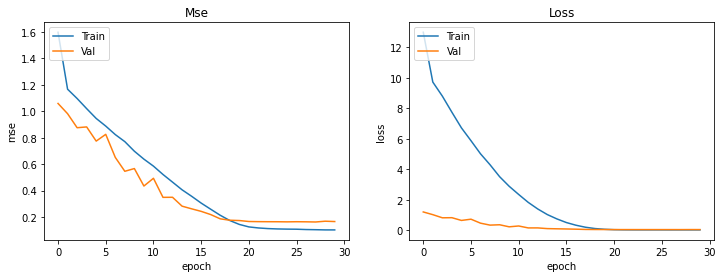

In [14]:
plot_history(history)

#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)


#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer



#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description



#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!